In [87]:
# Incase Of Update
# response = requests.get('https://db.ygoprodeck.com/api/v7/cardinfo.php')
# json_response = response.json()
# dataset = pd.DataFrame(json_response['data'])

# dataset.to_csv('Dataset/Yugioh_Database.csv')

In [209]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
from IPython.display import display, HTML , clear_output
import ast

import random as random
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


warnings.simplefilter(action='ignore', category=FutureWarning)
plt.style.use('Solarize_Light2')
pd.set_option('display.max_columns', 20)

#import requests
#import itertools

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0] , True)


In [89]:
# ========================================================================
'''Load Dataset'''
dataset = pd.read_csv('Dataset/Yugioh_Database.csv')
dataset = dataset.drop(['Unnamed: 0' , 'frameType' , 'archetype' , 'ygoprodeck_url' , 'card_sets' , 'card_prices' , 'banlist_info'],axis=1)
dataset = dataset[dataset['type'] != 'XYZ Pendulum Effect Monster']
dataset = dataset[dataset['type'] != 'Synchro Pendulum Effect Monster']
dataset = dataset[dataset['type'] != 'Fusion Pendulum Effect Monster']
dataset = dataset[dataset['type'] != 'Pendulum Effect Monster']
dataset = dataset[dataset['type'] != 'Pendulum Normal Monster']

dataset = dataset[dataset['type'] != 'Skill Card']
dataset = dataset[dataset['type'] != 'Monster Token']
	 
# dataset = dataset[dataset['type'] != 'Spell Card']
# dataset = dataset[dataset['type'] != 'Trap Card']
dataset = dataset[dataset['type'] != 'Fusion Monster']
dataset = dataset[dataset['type'] != 'XYZ Monster']
dataset = dataset[dataset['type'] != 'Synchro Monster']
dataset = dataset[dataset['type'] != 'Link Monster']
# Staple Removal
dataset = dataset[[not i for i in dataset['name'].isin(['Ash Blossom & Joyous Spring' , 'Effect Veiler' , 'Ghost Ogre & Snow Rabbit' ,'Ghost Belle & Haunted Mansion',
                                                        'Infinite Impermanence' , 'Red Reboot' , 'Called by the Grave' , 'Forbidden Droplet' , 'Crossout Designator',
                                                        'Nibiru, the Primal Being', 'Harpie\"s Feather Duster' , 'Lightning Storm' , 'Pot of Prosperity' , 'Pot of Desires',
                                                        'Pot of Duality' , 'Pot of Extravagance' , 'Triple Tactics Talents' , 'Torrential Tribute' , 'Dark Ruler No More' , 
                                                        'Red Reboot', 'D.D. Crow' , 'PSY-Framegear Gamma' , 'Maxx \"C\"' , 'Dimension Shifter' , 'Droll & Lock Bird' , 
                                                        'Accesscode Talker', 'Apollousa, Bow of the Goddess', 'Borreload Dragon' , 'Borrelsword Dragon', 'Knightmare Unicorn',
                                                        'Predaplant Verte Anaconda' , 'Knightmare Phoenix' , 'Knightmare Cerberus' , 'Underworld Goddess of the Closed World',
                                                        'Borreload Savage Dragon' , 'Token Collector' , 'Evenly Matched' , 'Forbidden Chalice' , 'Cosmic Cyclone' , 'Contact \"C\"',
                                                        'Retaliating \"C\"' , 'Gadarla, the Mystery Dust Kaiju' , 'Solemn Judgment' , 'Dimensional Barrier' , 'Solemn Strike',
                                                         'Ice Dragon\'s Prison' , 'Gozen Match' ])]]

dataset.loc[dataset['type']=='Normal Monster', ['desc']] = 'NoInfo'
dataset = dataset.fillna('0')
dataset['level'] = dataset['level'].astype('int32')



# ========================================================================
'''Create Tokenized sequence database'''


df = dataset['desc']         #Tokenizer is only trained on desc and based on that . Otherwise if trained on names it would blow vocab up to absurd amounts
Sliced_df = dataset[['level' , 'race' , 'type' , 'attribute' , 'name' , 'desc']]




Sliced_df = Sliced_df.reset_index(drop=True)            # Need to reset the indexes so they are consistent
df = df.reset_index(drop=True)
dataset = dataset.reset_index(drop=True)                              

tokenizer = Tokenizer(filters='\r , \n , \" ') # Speech marks stop names from being recognised by tokenizer
tokenizer.fit_on_texts(df)
tokenizer.word_index['0'] = 0           #Signifies Empty values

sequences = []
padded_sequences = []
Tokenized_sequence_database = []
count = 0
for i in Sliced_df.astype('string').to_numpy():
    
    sequences.append(tokenizer.texts_to_sequences(i))
    

for i in range(0,6):
    padded_sequences.append( pad_sequences(np.array(sequences , dtype='object')[:,i], padding='post') ) 

Tokenized_sequence_database = np.concatenate(([padded_sequences[i] for i in range(6)]) , axis=1 )

    




In [90]:
def Deck_Loader(directory):
    '''Loads Decks from Deck_Lists.txt as arrays and stores those arrays in altered'''
    file = open(directory , 'r')
    read = file.readlines()
    Deck_Array = []
    flag = False

    temp=[]

    for count,line in enumerate(read):
        
        if '//' in read[count]:
            flag = not flag
        
        if flag:
            
            read[count] = read[count].replace('\n','')
            
            if ('=='  in read[count]) or ('//'  in read[count])  :
                pass
                
            else:
                for i in range(int(read[count][0])):
                    temp.append(read[count][1:].strip())          #skip appending also remove white space

        if (not flag) or (count == len(read) - 1):
            Deck_Array.append(temp)
            temp = []
            flag = not flag
            
            
    file.close()
    return Deck_Array 

def Dataset_Builder(Direc):
    Loaded_Decks = Deck_Loader(Direc)

    Output = []
    for Deck in Loaded_Decks:
        for _ in range(30):
            choices = Sliced_df[Sliced_df['name'].isin(Deck)].index.values          # Prevents staples from leaking into data as sliceddf is filtered from staples.

            indexes = random.sample(choices.tolist() , 5)
            Decider = np.concatenate([Tokenized_sequence_database[i] for i in indexes])
            
            Output.append([Decider , [1]])

    for _ in range(len(Output)):
        Decks = random.sample(Loaded_Decks , 5)
        choices1 = Sliced_df[Sliced_df['name'].isin(Decks[0])].index.values 
        choices2 = Sliced_df[Sliced_df['name'].isin(Decks[1])].index.values
        choices3 = Sliced_df[Sliced_df['name'].isin(Decks[2])].index.values
        choices4 = Sliced_df[Sliced_df['name'].isin(Decks[3])].index.values
        choices5 = Sliced_df[Sliced_df['name'].isin(Decks[4])].index.values

        indexes = np.concatenate([random.choices(choices1.tolist() , k=1) , random.choices(choices2.tolist() , k=1) , random.choices(choices3.tolist() , k=1) , random.choices(choices4.tolist() , k=1) , random.choices(choices5.tolist() , k=1)])

        Decider = np.concatenate([Tokenized_sequence_database[i] for i in indexes])

        Output.append([Decider , [0]])
    
    random.shuffle(Output)
    random.shuffle(Output)
    random.shuffle(Output)
    return Output

Training_Dataset = Dataset_Builder('Dataset/Training_Deck_Lists.txt')
#Validation_Dataset = Dataset_Builder('Dataset/Validation_Deck_Lists.txt')


#pd.DataFrame(Training_Dataset)
#x,y = Training_Dataset[0][0]
#tokenizer.sequences_to_texts(np.array(y))
#np.array(x).shape       

In [91]:
pd.DataFrame(Training_Dataset)

,0,1
0,"[0, 760, 0, 74, 5, 0, 0, 0, 772, 5584, 3552, 0...",[0]
1,"[7, 295, 150, 21, 8, 0, 0, 305, 1070, 200, 489...",[0]
2,"[0, 760, 0, 74, 5, 0, 0, 0, 772, 5584, 3552, 0...",[1]
3,"[137, 295, 150, 21, 8, 0, 0, 305, 494, 0, 0, 0...",[0]
4,"[0, 49, 0, 74, 5, 0, 0, 0, 2, 3731, 10, 1134, ...",[0]
...,...,...
415,"[0, 49, 0, 74, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",[0]
416,"[0, 760, 0, 74, 5, 0, 0, 0, 139, 246, 4472, 0,...",[1]
417,"[376, 112, 0, 21, 8, 0, 0, 305, 494, 3004, 0, ...",[1]
418,"[0, 49, 0, 74, 5, 0, 0, 0, 1682, 1491, 3191, 0...",[0]


In [109]:
def Train_Split_Gen():
    seti0 = [i[0] for i in Training_Dataset]
    seti1 = [i[1] for i in Training_Dataset]
    
    for _ in range(100000):
        r_int = random.randint(0 , int(len(Training_Dataset)*0.8) - 5)
        train_seti0 = tf.convert_to_tensor(seti0[r_int:r_int+5] , dtype='float32')
        train_seti1 = tf.convert_to_tensor(seti1[r_int:r_int+5], dtype='float32')
        
    
        yield train_seti0,train_seti1

def Val_Split_Gen():
    seti0 = [i[0] for i in Training_Dataset]
    seti1 = [i[1] for i in Training_Dataset]
    
    for _ in range(100000):
        r_int = random.randint(int(len(Training_Dataset)*0.8) , len(Training_Dataset) - 50)
        train_seti0 = tf.convert_to_tensor(seti0[r_int:r_int+50] , dtype='float32')
        train_seti1 = tf.convert_to_tensor(seti1[r_int:r_int+50] , dtype='float32')
                  
    
        yield train_seti0,train_seti1

def Pred_Split_Gen():
    seti0 = [i[0] for i in Training_Dataset]
    seti1 = [i[1] for i in Training_Dataset]
    
    for _ in range(1):
        r_int = random.randint(int(len(Training_Dataset)*0.8) , len(Training_Dataset) - 50)
        train_seti0 = tf.convert_to_tensor(seti0[r_int:r_int+50] , dtype='float32')
        train_seti1 = tf.convert_to_tensor(seti1[r_int:r_int+50] , dtype='float32')
                  
    
        yield train_seti0,train_seti1

In [201]:
### Run to train a new model

# Model = FullModel(200 , 5000 , 200 *2 , 0.1 , 1)

# learning_rate = CustomSchedule(d_model = 200)

# optimizer = tf.keras.optimizers.Adam(learning_rate , beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# tensorboard_callback = keras.callbacks.TensorBoard(
#     log_dir='Logs/Logs24' ,histogram_freq=1
# )
 
# Model.compile(
#     loss= tf.keras.losses.BinaryCrossentropy(),
#     optimizer=optimizer,
#     metrics= 'accuracy' )

# history = Model.fit(Train_Split_Gen() , epochs=4, 
#                                validation_data = Val_Split_Gen()  , steps_per_epoch=40 , batch_size=5 , 
#                                validation_steps=50 , validation_batch_size=50 , callbacks=[tensorboard_callback] )

#Model.save_weights('Saved_Models/___')

In [ ]:
### Run to Load a Model 
ArchivedModel = FullModel(225 , 5000 , 225 *2 , 0.1 , 1)
ArchivedModel.load_weights('Saved_Models/Model6220/Model6220_Weights')

2/2 [==============================] - 0s 27ms/step


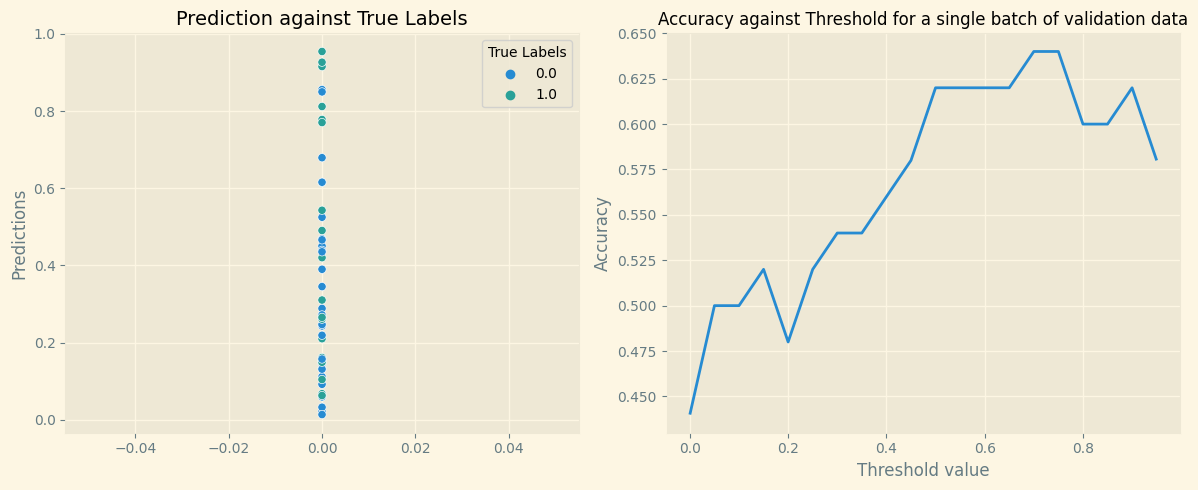

In [205]:
def ModelStats(Model):
    '''Pass in a trained Model to see some stats about it'''
    
    Data , True_Labels = next(Pred_Split_Gen())
    Predictions = Model.predict(Data)
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    vals = pd.DataFrame([{'z' : 0 ,'x' : i[0],'y' : j[0]} for i,j in zip(Predictions , True_Labels.numpy())])

    ### Plot prediction values against true Labels
    sns.scatterplot(data=vals , x='z' , y='x' , hue='y' , ax=axes[0])
    axes[0].set_title('Prediction against True Labels' , fontsize=14)
    axes[0].set_xlabel('')
    axes[0].set_ylabel('Predictions')
    axes[0].legend(title='True Labels')
    

    Accuracy = []
    Threshold = []
    for threshold in range(0,20,1):
        count = 0
        for i in vals.values:
            if i[1] > threshold/20:
                pred = 1
            else:
                pred = 0
            
            if pred == i[2]:
                count+=1
        
        Accuracy.append(count/len(vals))
        Threshold.append(threshold/20)
    
    sns.lineplot(x=Threshold , y=Accuracy ,ax=axes[1])
    axes[1].set_title('Accuracy against Threshold for a single batch of validation data' , fontsize=12)
    axes[1].set_xlabel('Threshold value')
    axes[1].set_ylabel('Accuracy')
    plt.tight_layout()
    

ModelStats(Model)

In [ ]:
def Model_tester(Model , input_array):
    ''' Gives a prediction on how related a group of 5 cards are'''
    indexes = Sliced_df[Sliced_df['name'].isin(input_array)].index.values
    Decider = tf.convert_to_tensor([ np.concatenate([Tokenized_sequence_database[i] for i in indexes])    ])

    return Model(Decider)


input_array = ['Galaxy-Eyes Photon Dragon' , 'Junk Converter'  , 'Doppelwarrior',  'Bystial Baldrake'   , 'Road Synchron' ]

Model_tester(Model ,input_array)


In [238]:
def predict_matches(start , end , threshold  , input_array , Model):
    
    
    indexes = Sliced_df[Sliced_df['name'].isin(input_array)].index.values
    Incomplete_Decider = np.concatenate([Tokenized_sequence_database[i] for i in indexes])

    count = 0
    chosen_indexes = []
    for indx in pd.DataFrame(Tokenized_sequence_database).index.values:
        if count<start:
            pass
        elif count<end:
            if (count % 100) == 0:
                print(count)
            Decider = tf.convert_to_tensor([np.concatenate([ Incomplete_Decider  , Tokenized_sequence_database[indx] ])])
            
            
            if Model.predict(Decider , verbose=False)[0][0] > threshold:
                #print(Sliced_df[indx:indx+1]['name'])
                chosen_indexes.append(indx)
                
                
                
                
        count+=1

    image_urls = [ast.literal_eval(dataset['card_images'][i])[0]['image_url'] for i in chosen_indexes]
    image_html = ''.join([f'<img src="{url}" style="width:340px; margin:10px; display:inline-block;">' for url in image_urls])
    display(HTML(image_html))


input_array = ['Galaxy Wizard' , 'Galaxy Soldier' , 'Photon Orbital' , 'Galaxy-Eyes Photon Dragon' ]

predict_matches(1000, 5000 , 0.5 ,input_array , ArchivedModel )


1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900


NameError: name 'Experimentation_Gen' is not defined

["2 aqua effect monster water cannot be used as a synchro material. this card's name becomes des frog while it is on the field. if this card is in your graveyard: you can banish 1 frog monster from your graveyard; special summon this card."]

array([1065,   -1,  398,    0,   -1,  294,   20,    8,    0,   -1,  251,
         -1, 1618,   10,    5,  731,    0,    0,    0,    0,    0,   -1,
        200,    1,    6,   87,    7,   10,  231,  508,   78,  134,   83,
        315,   78,  129,   89,   75,   22,  113,   76,   38,    5,   44,
          9,    5,   47,   78,   58,   89,   32,    3,   42,  262,   78,
        384,  125,    3,   48,   29,   98,  197,    7,    4,   13,  140,
         29,  188,    5,   92,    1,    6,   24,   31,    2,   20,   10,
       1618,   10,    5,  731,   18,   19,   25,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

Instructions for updating:
use `tf.profiler.experimental.start` instead.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
Instructions for updating:
`tf.python.eager.profiler` has deprecated, use `tf.profiler` instead.
Instructions for updating:
`tf.python.eager.profiler` has deprecated, use `tf.profiler` instead.
